In [1]:
%matplotlib notebook
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.time import Time
from matplotlib import cm
import astropy.io.fits as pf
params = {#"figure.figsize": (12,9),
          "font.size": 15,
          "font.weight": "normal",
          "xtick.major.size": 6,
          "xtick.minor.size": 4,
          "ytick.major.size": 6,
          "ytick.minor.size": 4,
          "xtick.major.width": 3,
          "xtick.minor.width": 2,
          "ytick.major.width": 3,
          "ytick.minor.width": 2,
          "xtick.major.pad": 5,
          "xtick.minor.pad": 5,
          "ytick.major.pad": 5,
          "ytick.minor.pad": 5,
          "lines.linewidth": 2,
          "lines.markersize": 15,
          "axes.linewidth": 2,
          "axes.labelsize": 20,

          "legend.loc": "best",
          "text.usetex": False,    
          "xtick.labelsize" : 15,
          "ytick.labelsize" : 15,
          "savefig.dpi" : 600,
        'legend.markerscale': 1.0
          }
import matplotlib
matplotlib.rcParams.update(params)

In [2]:

file_lc = './Data/tess2021146024351-s0039-0000000111898820-0210-s_lc.fits'

In [3]:
def rebin(arr, new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
                 new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)


In [4]:
def dateLabels(ax):
    """
    Small function to create a top x-axis on light curve plots with dates in iso format (2018-10-09).
    Takes the current axis and generates a new identical one. Generates new labels at the same tick positions as those set
    automatically by matplotlib using astropy Time. Set the new axes ticks & labels to these values,
    ensuring the same xlimits kept

    """
    ax2 = ax.twiny()
    #NOTE THE FUDGE FACTOR TO DEAL WITH TJD NOT MJD
    #TESS JD = MJD-56999.5
    ticks = ax.get_xticks()
    labels = Time(ticks+56999.5, format='mjd').to_value('iso',subfmt='date')

    ax2.set_xticks(ticks)
    ax2.set_xticklabels(labels, size=12)
    ax2.set_xlim(ax.get_xlim())
    
    return ax2

<IPython.core.display.Javascript object>


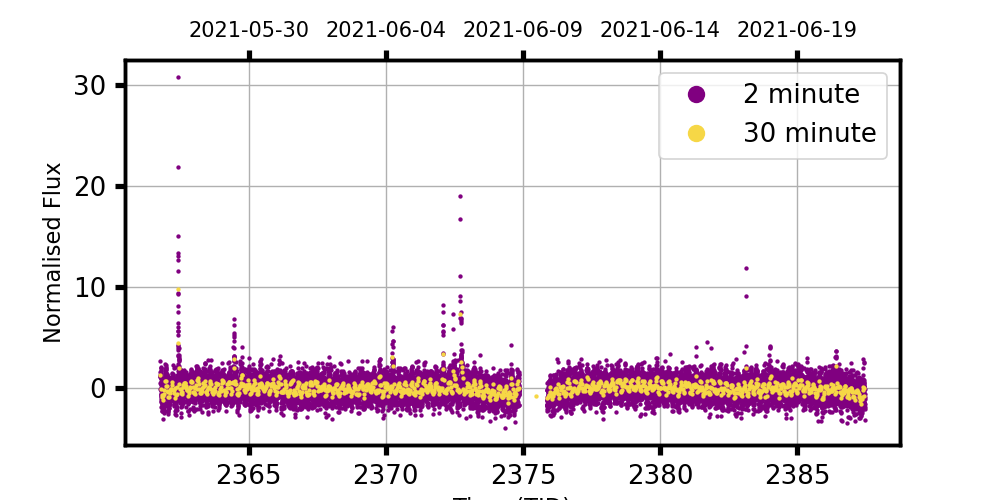

In [5]:
binfac = 15
#2 min cadence natively, so factor 15 = 30 mins
c2=cm.inferno(0.9)
fig, ax = plt.subplots(figsize=(8,4))
hdul  = pf.open(file_lc)

tic     = int(hdul[0].header['TICID'])
data = hdul[1].data

teff    = hdul[0].header['TEFF']
srad    = hdul[0].header['RADIUS']
time    = data['TIME']
flux    = data['PDCSAP_FLUX']
qual    = data['QUALITY']

hdul.close()

t0      = time[0]   # start time
tf      = time[-1]
l       = np.isfinite(time) * np.isfinite(flux) * (qual == 0)  # create a mask that only selects finite values and ot flagged (by TESS pipeline) data points. 
time    = time[l]
flux    = flux[l]

m       = np.median(flux)    
flux    = 1e2 * ((flux / m) - 1)     # normlise to 0 
N       = len(time)

n       = int(np.floor(N/binfac)*binfac)    # bin the data 
X       = np.zeros((2,n))
X[0,:]  = time[:n]
X[1,:]  = flux[:n]
Xb      = rebin(X, (2,int(n/binfac)))
time1    = Xb[0]
flux1    = Xb[1]


plt.plot(time, flux, color = 'purple', ms = 3, marker = '.', lw = 0, label = '2 minute')
plt.plot(time1, flux1, color = c2, ms = 3, marker = '.', lw = 0, label = '30 minute')
plt.legend(fontsize = 13)
plt.xlabel("Time (TJD)", fontsize = 13)
plt.ylabel("Normalised Flux", fontsize = 13)
lgnd = plt.legend(markerscale=6)
plt.grid(True)

dateLabels(ax)

#plt.savefig('Figures/' + 'TESS_LC.png', bbox_inches = 'tight')
#plt.savefig('Figures/' + 'TESS_LC.pdf', bbox_inches = 'tight')
plt.show()

In [6]:
lc = lk.lightcurve.LightCurve(time = time, flux = flux)
pg = lc.normalize(unit='ppm').to_periodogram()
f,p,P = pg.frequency_at_max_power*u.day ,pg.max_power,pg.period_at_max_power
print(f,p,P)
#error on Period?? MUST be greater than nyquist limit of 2 minute sampling. FWHM is indeed bigger (0.6% vs 1.1%)
# if we assumed the profile to be Gaussian this would reduce the errP by 2sqrt(2ln2). But im not assuming that.
errP = P*((4.3884-4.3416)/f)

lcbin = lk.lightcurve.LightCurve(time = time1, flux = flux1)
pgbin = lcbin.normalize(unit='ppm').to_periodogram()
fbin,pbin,Pbin = pgbin.frequency_at_max_power*u.day ,pgbin.max_power,pgbin.period_at_max_power

/home/alex/anaconda3/lib/python3.7/site-packages/lightkurve/lightcurve.py:1048: LightkurveWarning: The light curve appears to be zero-centered (median=2.98e-06 +/- 1.10e+00); `normalize()` will divide the light curve by a value close to zero, which is probably not what you want.
  LightkurveWarning,


4.362155362252157 173621463250.421 ppm 0.22924447135777978 d


/home/alex/anaconda3/lib/python3.7/site-packages/lightkurve/lightcurve.py:1048: LightkurveWarning: The light curve appears to be zero-centered (median=-2.42e-02 +/- 6.49e-01); `normalize()` will divide the light curve by a value close to zero, which is probably not what you want.
  LightkurveWarning,
/home/alex/anaconda3/lib/python3.7/site-packages/lightkurve/lightcurve.py:1058: LightkurveWarning: The light curve has a negative median flux (-2.42e-02); `normalize()` will therefore divide by a negative number and invert the light curve, which is probablynot what you want
  LightkurveWarning,


<IPython.core.display.Javascript object>


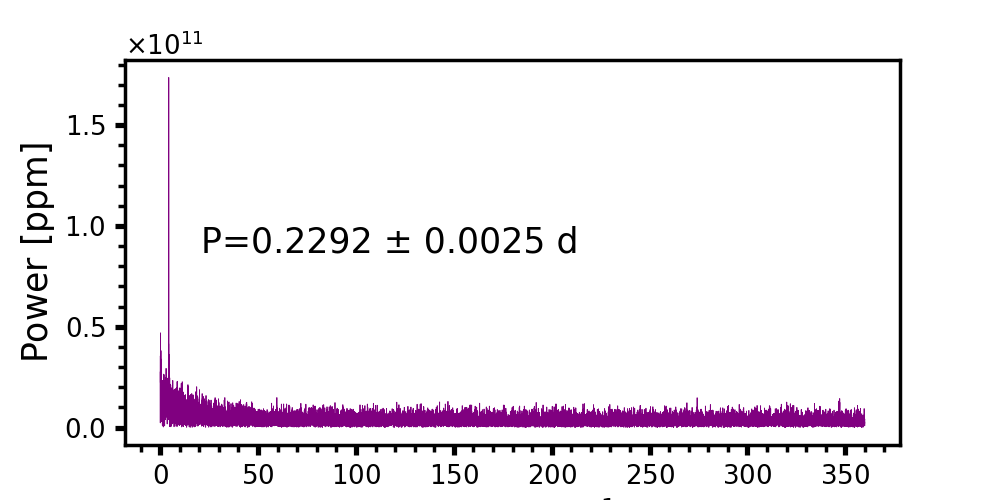

<AxesSubplot:xlabel='Frequency [$\\mathrm{\\frac{1}{d}}$]', ylabel='Power [$\\mathrm{ppm}$]'>

In [7]:
fig, axpg = plt.subplots(figsize=(8,4))
axpg.text(f+5,p*0.5e6,s = '  P={:.4f} ± {:.4f}'.format(P.value, errP), fontsize=20)
pg.plot(ax=axpg, color='purple')

#plt.savefig('Figures/' + 'TESS_pg.png', bbox_inches = 'tight')
#plt.savefig('Figures/' + 'TESS_pg.pdf', bbox_inches = 'tight')


In [8]:
'''we are pretty sure this is a sine curve. no harmonics.
To get the best fit to our data let's actually fit one:
'''
from scipy.optimize import leastsq
from scipy import optimize

guess_amp = 0.5 # looks to be 0.5
guess_freq = f #which we've already defined!
guess_phase=1
guess_offset = 0 # we've already normalised to 0

#best to fold our data at this 'guess'
Phase = np.array([(val*f)%1 for val in time])
PhaseBin = np.array([(val*fbin)%1 for val in time1])

def test_sin(t,A,f,ph,y0):
    return A*np.sin(2*np.pi*f*t + ph) + y0

params, params_cov = optimize.curve_fit(test_sin, time, flux, p0=[guess_amp, guess_freq,guess_phase,guess_offset])
#paramsBin, params_covBin = optimize.curve_fit(test_sin, time1, flux1, p0=[guess_amp, guess_freq,guess_phase,guess_offset])

print(params)
#params: amplitude ~0.52, period bang on, a phase offset in days and a small y offset (expected)
print([params_cov[i][i] for i in range(4)])
#print([params_covBin[i][i] for i in range(4)])


[ 5.22144877e-01  4.36500784e+00 -4.28694429e+01  2.53242710e-02]
[0.00012299036578624132, 1.954666330158665e-07, 43.51080630840589, 6.009051314058264e-05]


<IPython.core.display.Javascript object>


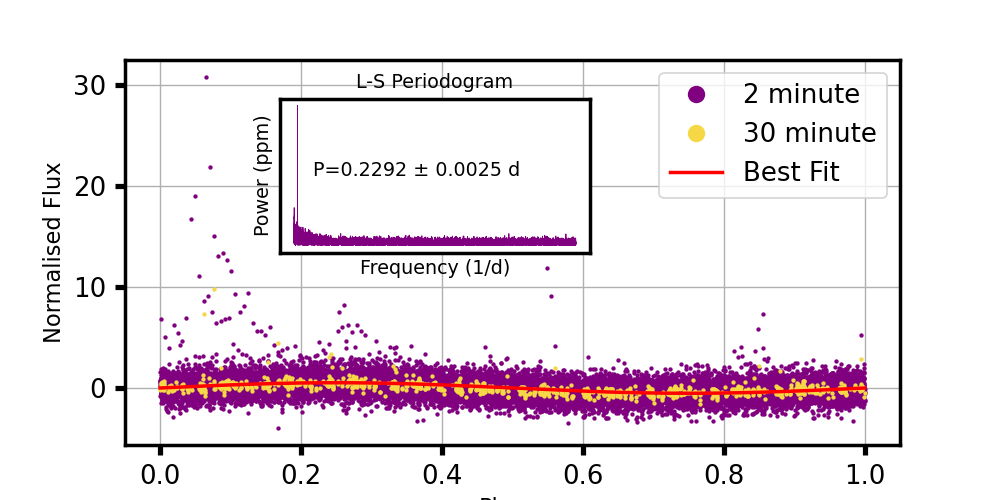

In [9]:
# recreate the fitted curves using the optimized parameters
# also rephase the data for an exact match

x=np.linspace(0,1,500)
y_fit = params[0]*np.sin(2*np.pi*x) + params[3]
#y_fit_bin = paramsBin[0]*np.sin(2*np.pi*x) + paramsBin[3]

rePhase= np.array([(val*params[1]+params[2])%1 for val in time])
rePhaseBin = np.array([(val*params[1]+params[2])%1 for val in time1])


plt.figure(figsize=(8,4))
ax=plt.gca()

plt.plot(rePhase, flux, color = 'purple', ms = 3, marker = '.', lw = 0, label = '2 minute')
plt.plot(rePhaseBin, flux1, color = c2, ms = 3, marker = '.', lw = 0, label = '30 minute')
plt.plot(x,y_fit, label = 'Best Fit',color='red')

plt.xlabel("Phase", fontsize = 13)
plt.ylabel("Normalised Flux", fontsize = 13)
plt.legend(markerscale=6)
plt.grid(True)


axpg = ax.inset_axes([0.2, 0.5, .4, .4])
pg.plot(ax=axpg, color='purple')
axpg.text(f+20,p*0.5e6,s = 'P={:.4f} ± {:.4f}'.format(P.value, errP), fontsize=11)
axpg.set_title('L-S Periodogram', fontsize=11)
axpg.set_xlabel('Frequency (1/d)', fontsize=11)
axpg.set_ylabel('Power (ppm)', fontsize=11)
axpg.set_yticks([])
axpg.set_xticks([])


#plt.savefig('Figures/' + 'TESS_phase.png', bbox_inches = 'tight')
#plt.savefig('Figures/' + 'TESS_phase.pdf', bbox_inches = 'tight')

plt.show()

<IPython.core.display.Javascript object>


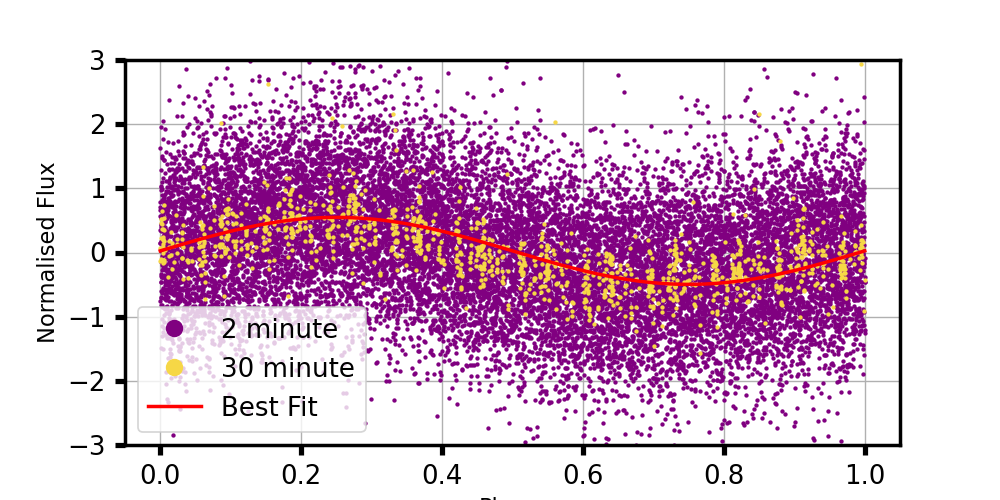

In [10]:
#just a zoomed in version
plt.figure(figsize=(8,4))
ax=plt.gca()
from matplotlib import cm
plt.plot(rePhase, flux, color = 'purple', ms = 3, marker = '.', lw = 0, label = '2 minute')
plt.plot(rePhaseBin, flux1, color = c2, ms = 3, marker = '.', lw = 0, label = '30 minute')

plt.plot(x,y_fit, label = 'Best Fit',color='red')

plt.legend(fontsize = 13)
plt.xlabel("Phase", fontsize = 13)
plt.ylabel("Normalised Flux", fontsize = 13)
lgnd = plt.legend(markerscale=6)
plt.grid(True)
plt.ylim(-3,3)

#plt.savefig('Figures/' + 'TESS_Crop.png', bbox_inches = 'tight')
#plt.savefig('Figures/' + 'TESS_Crop.pdf', bbox_inches = 'tight')

plt.show()

In [11]:
#calculation of equatorial velocity of rotation - does this match with the spectroscopy?
#v = 2pi/P * R(in solar radii)
v = 2*np.pi * srad* 696340  / (P*24*60*60)
errV = np.sqrt((0.004/srad)**2+(errP/P)**2)*v
print('v = ',v*u.d,'±',errV*u.km*u.d*1.0/u.s)

v =  32.15190765954218 ± 0.9485311316745311 km / s
